In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.optim as optim
import torch.nn as nn
from scipy.stats import multivariate_normal

In [2]:
workdir='/home/jorge/Documents/PhD_proj2/'
os.chdir(workdir)

Load samples:

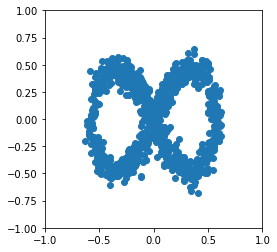

In [19]:
# Load samples for plot
sdir = 'VAE_lem'
d = np.load('./{0}/true_d.npy'.format(sdir))

fig, ax = plt.subplots()

ax.plot(d[:,0],d[:,1],'o')
ax.set_xlim([-1.0,1.0])
ax.set_ylim([-1.0,1.0])
ax.set_aspect('equal', adjustable='box')

or generate new samples:

In [294]:
# Define loss weights
beta = 0.001
veps = 1.0

Learn VAE that generates new samples with the same model:

In [295]:
# DNNs for VAE
class VAE(nn.Module):
    def __init__(self):
        super(VAE,self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(2,20),
            nn.Tanh(),
            nn.Linear(20,30),
            nn.Softplus(),
            nn.Linear(30,40),
            nn.ReLU(),
            nn.Linear(40,30),
            nn.Softplus(),
            nn.Linear(30,20),
            nn.Tanh()
        )
        self.fc1 = nn.Linear(20,2)
        self.fc2 = nn.Linear(20,2)
        self.fc3 = nn.Linear(2,20)
        self.decoder = nn.Sequential(
            nn.Linear(20,30),
            nn.Tanh(),
            nn.Linear(30,40),
            nn.ReLU(),
            nn.Linear(40,30),
            nn.Softplus(),
            nn.Linear(30,20),
            nn.Softplus(),
            nn.Linear(20,2),
            nn.Tanh()
        )
        
    def reparameterize(self, mu, logvar):    
        std = logvar.mul(0.5).exp_()
        esp = torch.randn(mu.size())
        z = mu + std*veps*esp
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z
        
    def forward(self, x):
        z, mu, logvar = self.encode(x)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

In [296]:
# Loss function
def loss_fn(recon_x, x, mu, logvar):
    MSE = nn.functional.mse_loss(recon_x, x, reduction='mean')
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return MSE + beta*KLD, MSE, KLD

In [297]:
# Define model to be trained.
model = VAE()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [298]:
epochs = 200
batch_size = 50
nsamps = d.shape[0]

model.train()

for epoch in range(epochs):
    for i in range(batch_size):
        rind = np.random.randint(nsamps)
        st = torch.Tensor(d[rind])
        recon_s, mu, logvar = model(st)
        loss, mse, kld = loss_fn(recon_s, st, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    #if i%(batch_size-1) == 0:
    to_print = "Epoch[{}/{}] Loss: {:.2e} {:.2e} {:.2e}".format(epoch+1, 
                        epochs, loss.item()/batch_size, mse.item()/batch_size, kld.item()/batch_size)
    print(to_print)

Epoch[1/200] Loss: 5.14e-05 5.12e-05 2.05e-04
Epoch[2/200] Loss: 4.12e-03 4.12e-03 3.03e-04
Epoch[3/200] Loss: 4.34e-03 4.34e-03 7.28e-04
Epoch[4/200] Loss: 2.81e-03 2.81e-03 7.79e-04
Epoch[5/200] Loss: 1.55e-03 1.55e-03 4.81e-04
Epoch[6/200] Loss: 1.52e-03 1.52e-03 3.35e-04
Epoch[7/200] Loss: 4.41e-03 4.41e-03 3.72e-04
Epoch[8/200] Loss: 1.78e-03 1.78e-03 2.23e-03
Epoch[9/200] Loss: 2.83e-04 2.70e-04 1.30e-02
Epoch[10/200] Loss: 4.51e-04 4.05e-04 4.57e-02
Epoch[11/200] Loss: 4.32e-04 4.17e-04 1.49e-02
Epoch[12/200] Loss: 2.40e-03 2.39e-03 7.33e-03
Epoch[13/200] Loss: 1.53e-03 1.47e-03 6.12e-02
Epoch[14/200] Loss: 2.07e-03 2.04e-03 3.31e-02
Epoch[15/200] Loss: 1.22e-03 1.19e-03 3.25e-02
Epoch[16/200] Loss: 7.46e-05 6.42e-05 1.04e-02
Epoch[17/200] Loss: 3.41e-03 3.39e-03 1.47e-02
Epoch[18/200] Loss: 4.38e-04 3.76e-04 6.19e-02
Epoch[19/200] Loss: 4.67e-04 4.51e-04 1.58e-02
Epoch[20/200] Loss: 2.28e-03 2.27e-03 1.35e-02
Epoch[21/200] Loss: 1.36e-04 1.21e-04 1.52e-02
Epoch[22/200] Loss: 1.

Epoch[176/200] Loss: 8.88e-05 3.80e-05 5.08e-02
Epoch[177/200] Loss: 9.18e-05 4.59e-05 4.59e-02
Epoch[178/200] Loss: 5.18e-05 4.92e-06 4.69e-02
Epoch[179/200] Loss: 8.27e-05 2.87e-05 5.40e-02
Epoch[180/200] Loss: 4.98e-05 2.39e-06 4.74e-02
Epoch[181/200] Loss: 8.01e-05 2.52e-05 5.49e-02
Epoch[182/200] Loss: 8.73e-05 4.06e-05 4.67e-02
Epoch[183/200] Loss: 2.62e-04 2.12e-04 5.03e-02
Epoch[184/200] Loss: 6.59e-05 1.23e-05 5.36e-02
Epoch[185/200] Loss: 7.00e-05 1.85e-05 5.14e-02
Epoch[186/200] Loss: 6.52e-05 9.13e-06 5.60e-02
Epoch[187/200] Loss: 5.25e-05 3.71e-06 4.88e-02
Epoch[188/200] Loss: 8.42e-05 3.68e-05 4.74e-02
Epoch[189/200] Loss: 2.26e-04 1.78e-04 4.85e-02
Epoch[190/200] Loss: 2.52e-04 1.96e-04 5.57e-02
Epoch[191/200] Loss: 2.10e-04 1.55e-04 5.54e-02
Epoch[192/200] Loss: 1.14e-04 5.15e-05 6.24e-02
Epoch[193/200] Loss: 5.81e-05 1.02e-05 4.79e-02
Epoch[194/200] Loss: 6.82e-05 1.82e-05 5.00e-02
Epoch[195/200] Loss: 1.42e-04 9.26e-05 4.94e-02
Epoch[196/200] Loss: 5.90e-05 1.13e-05 4

In [299]:
# Create lines for grid
u = np.linspace(-1.5,1.5,181)
#U,V = np.meshgrid(u,u)

# Extract lines from grid
stepl = 15
nlines = len(u)//stepl + 1
horl = np.zeros((nlines,len(u),2))
verl = np.zeros((nlines,len(u),2))
for i in range(nlines):
    horl[i,:,:] = np.column_stack((u[:],u[i*stepl]*np.ones(len(u))))
    verl[i,:,:] = np.column_stack((u[i*stepl]*np.ones(len(u)),u[:]))

#fig,ax = plt.subplots(figsize=(5,5))

#for i in range(nlines):
#    ax.plot(horl[i,:,0],horl[i,:,1],'k')
#    ax.plot(verl[i,:,0],verl[i,:,1],'k')
#ax.set_xlim([-2,2])
#ax.set_ylim([-2,2])
#ax.set_aspect('equal', adjustable='box')

#lns = np.row_stack((horl,verl))

hflat = horl.reshape(nlines*len(u),2)
vflat = verl.reshape(nlines*len(u),2)

#gridp = np.column_stack((U.flatten(),V.flatten()))
gridph = hflat
gridpv = vflat

In [300]:
# Build synthetic objective function
def quadratic_np(z,c,A):
    f = np.zeros(z.shape[0])
    for i in range(z.shape[0]):
        z_tras = z[i,:]-c
        f[i] = z_tras.T@A.T@A@z_tras
    return f

def lossamb(x):
    y = -multivariate_normal.pdf(x,(0.2,0.4),(0.3,0.3))
    #y = 0.001 + quadratic_np(x,(0.3,-0.3),np.diag(np.array([0.1,0.1])))
    return y

In [301]:
# Loss function in the latent space
xlat = np.arange(-2.0,2.1,0.1)
P,Q = np.meshgrid(xlat,xlat)

grdlosslat = np.column_stack((P.flatten(),Q.flatten()))

grdlossamb = model.decode(torch.Tensor(grdlosslat))
grdlossamb = grdlossamb.detach().numpy()

loss_lat = lossamb(grdlossamb)

# To compare with loss function in ambient space:
xamb = np.arange(-1.5,1.6,0.1)
Xamb,Yamb = np.meshgrid(xamb,xamb)
XYamb = np.column_stack((Xamb.flatten(),Yamb.flatten()))

loss_amb = lossamb(XYamb)
#loss_amb = np.log(loss_amb)
#loss_lat = np.log(loss_lat)

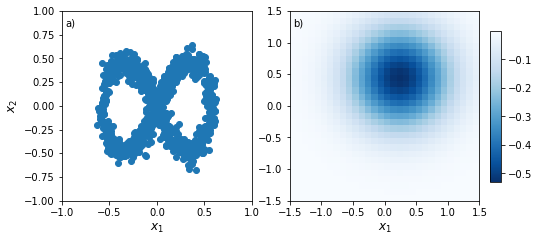

In [302]:
# Plot true samples and synthetic loss
fig, ax = plt.subplots(1,2,figsize=(7.48,3.5))

#ax[0].set_title('scaled ambient space')
ax[0].plot(d[:,0],d[:,1],'o')
ax[0].set_xlim([-1.0,1.0])
ax[0].set_ylim([-1.0,1.0])
ax[0].set_xlabel(r'$x_1$',fontsize=12)
ax[0].set_ylabel(r'$x_2$',fontsize=12)
ax[0].text(0.02, 0.92, 'a)', transform=ax[0].transAxes)
ax[0].set_aspect('equal', adjustable='box')

vmin = np.min(loss_amb) 
vmax = np.max(loss_amb)
#ax[1].set_title('Ambient space')
im = ax[1].pcolormesh(Xamb,Yamb,loss_amb.reshape(Xamb.shape),vmin=vmin,vmax=vmax,cmap='Blues_r')
ax[1].set_xlim([-1.5,1.5])
ax[1].set_ylim([-1.5,1.5])
ax[1].set_xlabel(r'$x_1$',fontsize=12)
ax[1].text(0.02, 0.92, 'b)', transform=ax[1].transAxes)
#ax[1].set_ylabel(r'$x_2$',fontsize=12)
ax[1].set_aspect('equal', adjustable='box')

cb_ax = fig.add_axes([0.92, 0.2, 0.02, 0.6])
fig.colorbar(im, cax=cb_ax)

In [303]:
#fig.savefig('trueobj.svg')

In [304]:
# Generate a few samples to plot
z_new = torch.randn(100,2)

d_new = model.decode(z_new)
d_new = d_new.detach().numpy()

In [305]:
# Encode-decode samples and decode gridlines
model.eval()

# Encode-decode true samples
_, mu_enc, s_enc = model.encode(torch.Tensor(d))
mu_enc = mu_enc.detach().numpy()
mu_encdec = model.decode(torch.Tensor(mu_enc))
mu_encdec = mu_encdec.detach().numpy()

# Decode grid
gridph_dec = model.decode(torch.Tensor(gridph))
gridph_dec = gridph_dec.detach().numpy()
gridpv_dec = model.decode(torch.Tensor(gridpv))
gridpv_dec = gridpv_dec.detach().numpy()


# destandardize gridlines
#gridp_dec = 2.0*dstds*gridp_dec + dmeans

#Udec,Vdec = gridp_dec[:,0].reshape(lns.shape), gridp_dec[:,1].reshape(V.shape)
horldec = gridph_dec.reshape(horl.shape)
verldec = gridpv_dec.reshape(verl.shape)

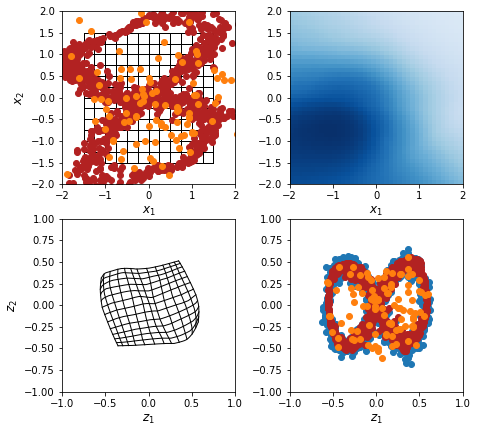

In [306]:
# Plot VAE generated samples and encoded samples

fig, ax = plt.subplots(2,2,figsize = (7.48,7))

for i in range(nlines):
    ax[0,0].plot(horl[i,:,0],horl[i,:,1],'k',linewidth=1)
    ax[0,0].plot(verl[i,:,0],verl[i,:,1],'k',linewidth=1)

#ax[0].set_title('latents, beta={0},veps={1}'.format(beta,veps))
ax[0,0].plot(mu_enc[:,0],mu_enc[:,1],'o',c='firebrick')
ax[0,0].plot(z_new[:,0],z_new[:,1],'o',c='tab:orange')

ax[0,0].set_xlim([-2.0,2.0])
ax[0,0].set_ylim([-2.0,2.0])
ax[0,0].set_xlabel(r'$x_1$',fontsize=12)
ax[0,0].set_ylabel(r'$x_2$',fontsize=12)
ax[0,0].set_aspect('equal', adjustable='box')

#ax[2].set_title('scaled ambient space')
ax[1,1].plot(d[:,0],d[:,1],'o')
ax[1,1].plot(mu_encdec[:,0],mu_encdec[:,1],'o',c='firebrick')
ax[1,1].plot(d_new[:,0],d_new[:,1],'o')
ax[1,1].set_xlim([-1.0,1.0])
ax[1,1].set_ylim([-1.0,1.0])
ax[1,1].set_xlabel(r'$z_1$',fontsize=12)
#ax[1,1].set_ylabel(r'$z_2$',fontsize=12)
ax[1,1].set_aspect('equal', adjustable='box')

# destandardize new data
#ds_new = 2.0*dstds*d_new + dmeans


#ax[2].set_title('ambient space')
#ax[2].plot(x,y,'o')
#ax[2].plot(ds_new[:,0],ds_new[:,1],'o')
#ax[2].set_xlim([-3,3])
#ax[2].set_ylim([-1.5,1.5])
#ax[2].set_aspect('equal', adjustable='box')

#fig, ax = plt.subplots()

#ax[2].set_title('scaled ambient space')
#for i in range(u.shape[0]):
#    ax[2].plot(Udec[:,i],Vdec[:,i],'k')
#    ax[2].plot(Udec[i,:],Vdec[i,:],'k')
#ax[2].set_xlim([-1.5,1.5])
#ax[2].set_ylim([-1.5,1.5])
#ax[2].set_aspect('equal', adjustable='box')

for i in range(nlines):
    ax[1,0].plot(horldec[i,:,0],horldec[i,:,1],'k',linewidth=1)
    ax[1,0].plot(verldec[i,:,0],verldec[i,:,1],'k',linewidth=1)
ax[1,0].set_xlim([-1.0,1.0])
ax[1,0].set_ylim([-1.0,1.0])
ax[1,0].set_xlabel(r'$z_1$',fontsize=12)
ax[1,0].set_ylabel(r'$z_2$',fontsize=12)
ax[1,0].set_aspect('equal', adjustable='box')

# Plot objective function in latent space

#ax[3].set_title('Latent space')
ax[0,1].pcolormesh(P,Q,loss_lat.reshape(P.shape),vmin=vmin,vmax=vmax,cmap='Blues_r')
ax[0,1].set_xlim([-2.0,2.0])
ax[0,1].set_ylim([-2.0,2.0])
ax[0,1].set_xlabel(r'$x_1$',fontsize=12)
#ax[0,1].set_ylabel(r'$x_2$',fontsize=12)
ax[0,1].set_aspect('equal', adjustable='box')

#fig.tight_layout()

In [ ]:
# get strings for saving
veps_str = str(veps)
veps_str = veps_str.replace('.','')
beta_str = str(beta)
beta_str = beta_str.replace('.','')

In [ ]:
# save figure
sfile = 'def_b{0}v{1}.svg'.format(beta_str,veps_str)
print('{0} saved'.format(sfile))
fig.savefig(sfile,dpi=300)

In [308]:
# create directory first time or only use as target for save when it already exists:
sdir = 'VAE_lem'
if sdir not in os.listdir():
    os.mkdir(sdir)

In [309]:
# save model state
torch.save(model.state_dict(), '/home/jorge/Documents/PhD_proj2/{0}/VAElemb{1}v{2}.pth'.format(sdir,beta_str,veps_str))

In [214]:
# Save samples for plot
sf = './{0}/true_d.npy'.format(sdir)
np.save(sf,d)